In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import calculations
from sklearn.cluster import KMeans


movies = pd.read_csv('https://sagemaker-us-east-2-714654521928.s3.us-east-2.amazonaws.com/dataset/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:
ratings = pd.read_csv('https://sagemaker-us-east-2-714654521928.s3.us-east-2.amazonaws.com/dataset/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


In [5]:
import calculations1
genre_ratings = calculations1.get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head(10)

     rating  rating
1      4.31    4.22
2      4.50    3.88
3      0.50    4.20
4      3.38    2.83
5      3.09    2.50
..      ...     ...
606    3.74    3.56
607    3.52    3.25
608    2.89    3.30
609    3.20    3.00
610    3.73    3.66

[610 rows x 2 columns]


,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50
6,3.61,3.48
7,2.65,3.15
8,3.50,3.25
9,3.17,3.00
10,3.33,2.00


In [6]:
biased_dataset = calculations1.bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


In [7]:
# dataset to list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

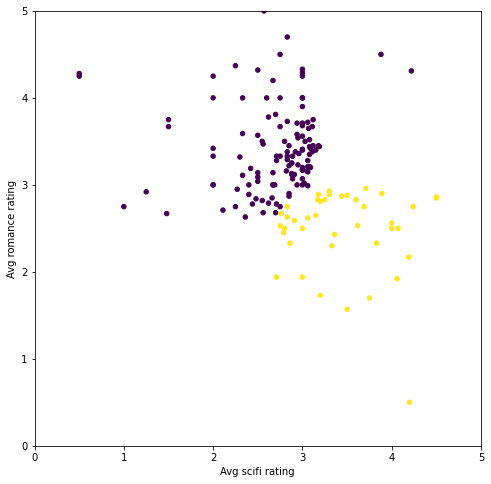

In [8]:
from sklearn.cluster import KMeans

# instance of k-means created to find two clusters
kmeans_1 = KMeans(n_clusters=2, random_state=0)

# to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# plot
calculations1.draw_clusters(biased_dataset, predictions)


In [9]:
# stride of 5 is taken to imporve performance 
possible_k_values = range(2, len(X)+1, 5)

# error values for all values of k are calculated 
errors_per_k = [calculations1.clustering_errors(k, X) for k in possible_k_values]


/home/ec2-user/SageMaker/calculations1.py:35: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)


In [18]:
list(zip(possible_k_values, errors_per_k))

[(2, 0.37651376343962917),
 (7, 0.37188663466396443),
 (12, 0.3807044295630311),
 (17, 0.38439729342295254),
 (22, 0.3775718946613467),
 (27, 0.41828437707930666),
 (32, 0.42578009851166765),
 (37, 0.41625756844166534),
 (42, 0.4324789023284599),
 (47, 0.41763785056947395),
 (52, 0.4244044526525227),
 (57, 0.38887603770925666),
 (62, 0.4147366164689675),
 (67, 0.39925755447186057),
 (72, 0.40030819512041826),
 (77, 0.3746588929923851),
 (82, 0.3760755834713649),
 (87, 0.36498819313409736),
 (92, 0.33564024153121597),
 (97, 0.3258902648209994),
 (102, 0.2948401270015159),
 (107, 0.2986536274269948),
 (112, 0.2704435948556259),
 (117, 0.2542305416600101),
 (122, 0.25153142682638563),
 (127, 0.22558571519757759),
 (132, 0.21179996908298948),
 (137, 0.19143078514136877),
 (142, 0.1745705045298946),
 (147, 0.13831784871757571),
 (152, 0.10678588096581217),
 (157, 0.06172839506172839),
 (162, 0.06172839506172839)]

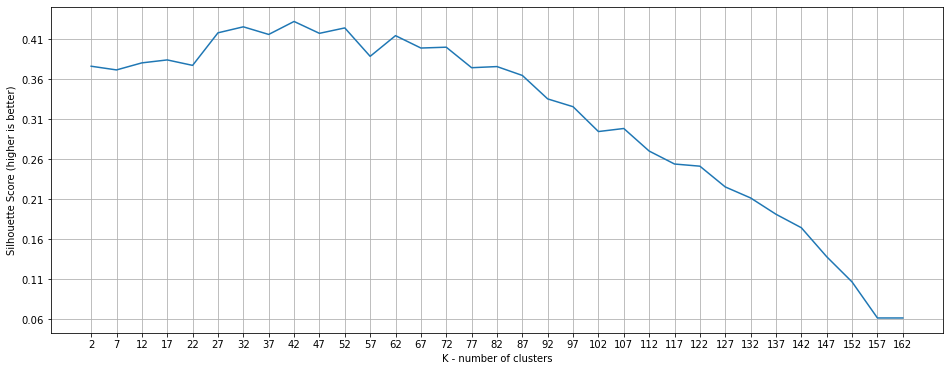

In [10]:
# plot of each value of k vs silhouette score atthat value of k
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)


# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')


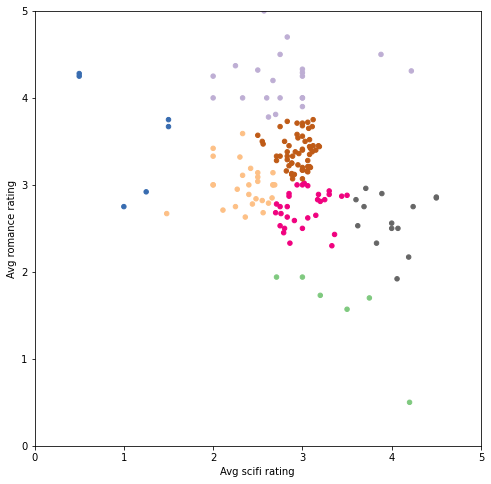

In [11]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7, random_state=6)

# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)

# Plot
calculations1.draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [12]:
# Merge the two tables then pivot so we have Users X Movies dataframe ('userid' vs 'user rating')
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print the number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]


dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# NaN means most of the users have not rated most of the movies
# Also known as Sparse or Low Dense Datasets

In [13]:
no_movies = 40
no_users = 20
most_rated_movies_users_selection = calculations1.sort_by_rating_density(user_movie_ratings, no_movies, no_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()


dataset dimensions:  (20, 40)


title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),Mission: Impossible (1996)
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,4.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,4.0,4.0,4.5,4.5,4.0,4.5,3.0,4.5,3.5,3.5
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0,...,2.5,4.0,3.5,5.0,3.5,3.5,4.5,3.5,5.0,3.0
589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,5.0,...,3.0,3.0,4.5,4.5,3.0,4.0,4.5,3.5,3.0,3.5
607,3.0,4.5,5.0,4.0,5.0,3.5,3.0,4.0,3.0,4.0,...,3.0,3.5,3.5,2.0,2.5,4.5,4.0,3.5,3.0,3.5


In [14]:
# Pivoted the dataset and choosing the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = calculations1.get_most_rated_movies(user_movie_ratings, 1000)


In [17]:
pd.__version__

'1.1.5'

In [ ]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

In [20]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:117: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


cluster # 16
# of users in cluster: 289. # of users in plot: 50


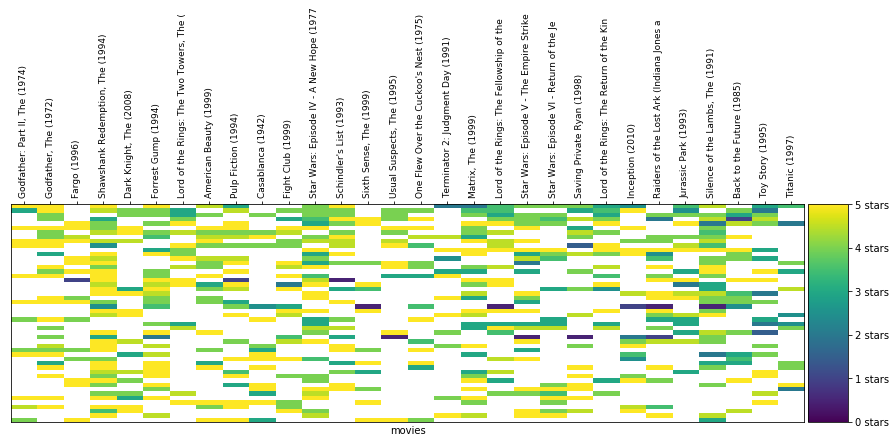

/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:117: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


cluster # 4
# of users in cluster: 85. # of users in plot: 50


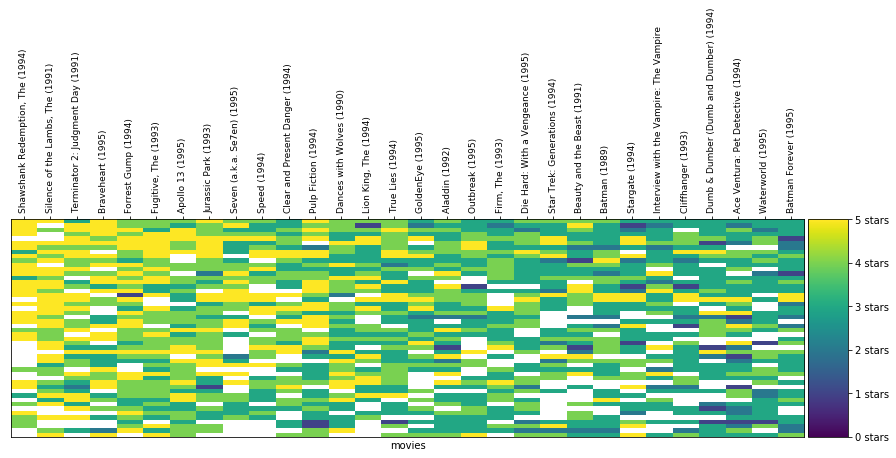

/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:117: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


cluster # 12
# of users in cluster: 63. # of users in plot: 50


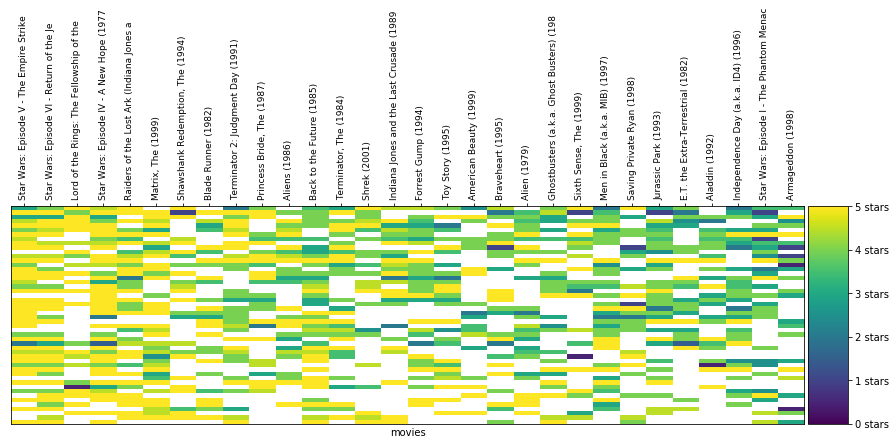

/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:117: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


cluster # 15
# of users in cluster: 46. # of users in plot: 46


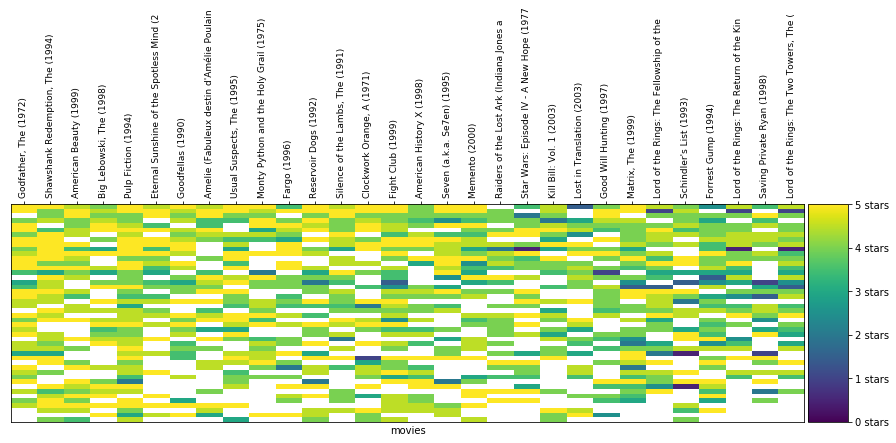

/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:117: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:117: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index

cluster # 5
# of users in cluster: 37. # of users in plot: 37


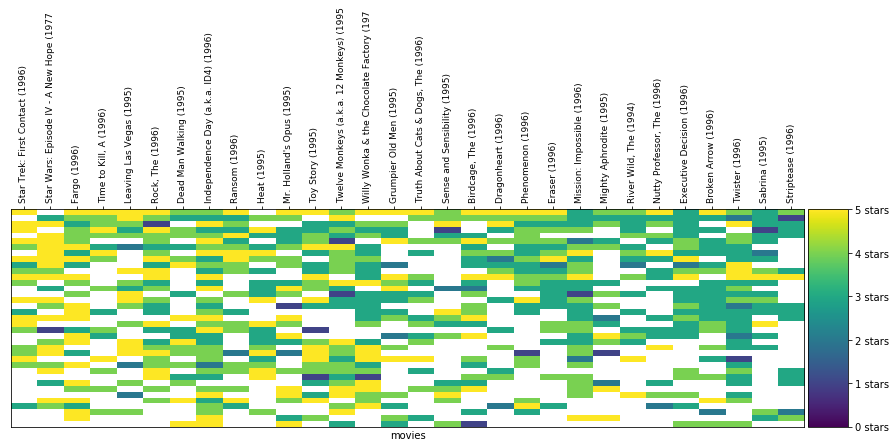

/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:117: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


cluster # 11
# of users in cluster: 34. # of users in plot: 34


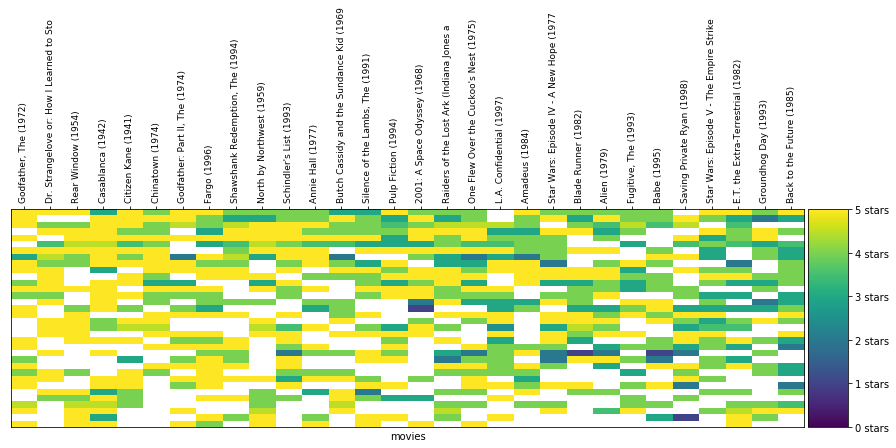

/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:117: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


cluster # 3
# of users in cluster: 25. # of users in plot: 25


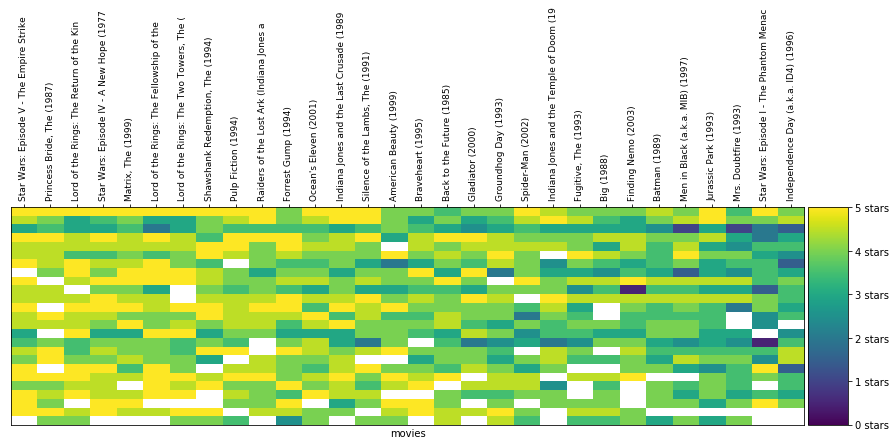

/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:117: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


cluster # 6
# of users in cluster: 52. # of users in plot: 50


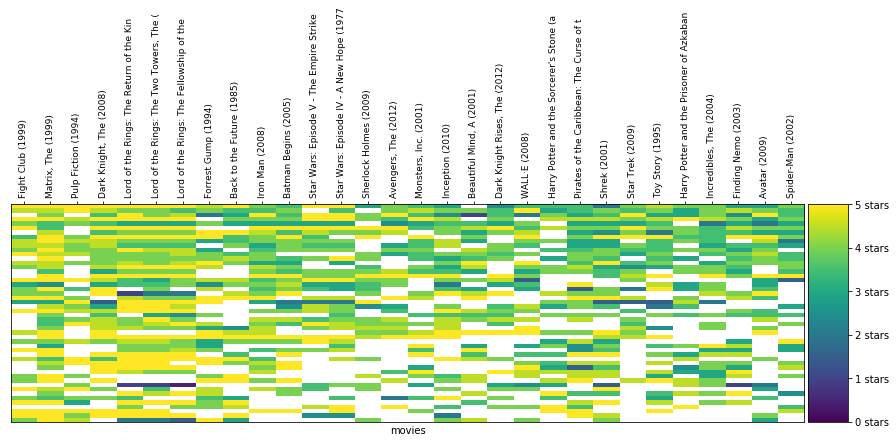

/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:117: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/home/ec2-user/SageMaker/Movie_Recommendation/calculations.py:117: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index

In [21]:
# Selecting the max number of users and movies heatmap cluster
max_users = 50
max_movies = 30

# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
calculations.draw_movie_clusters(clustered, max_users, max_movies)


# Prediction

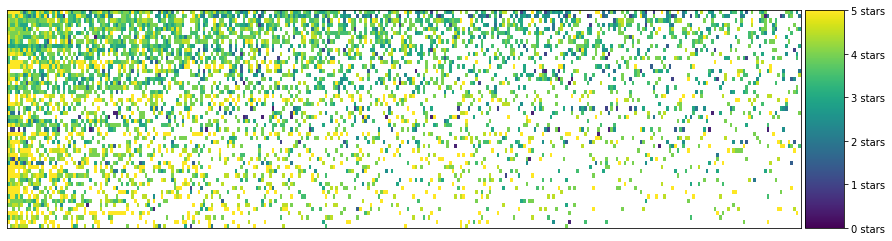

In [22]:
# cluster id is picked from one of the clusters above
cluster_number = 6

# region of the dataset with the most number of values 
no_users = 100
no_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

# sort and print the clusters
cluster = calculations.sort_by_rating_density(cluster, no_movies, no_users)
calculations.draw_movies_heatmap(cluster, axis_labels=False)


In [23]:
# ratings are printed 
cluster.fillna('').head()

,"Matrix, The (1999)","Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)","Dark Knight, The (2008)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Iron Man (2008),Shrek (2001),Pirates of the Caribbean: The Curse of the Black Pearl (2003),Forrest Gump (1994),Batman Begins (2005),...,Gattaca (1997),"Breakfast Club, The (1985)",10 Things I Hate About You (1999),Coyote Ugly (2000),Almost Famous (2000),Batman (1989),"Mummy, The (1999)","Nightmare Before Christmas, The (1993)",Dodgeball: A True Underdog Story (2004),What Women Want (2000)
37,5,5,5,5,5,4,2,3.5,4.5,3.5,...,,,,,4,4,3.5,,2.5,
19,4,4,5,3.5,4.5,5,3.5,3,2,3.5,...,,,1,2,,3.5,4,,,2
47,4.5,4,4,4.5,3.5,3.5,4,3.5,4,4,...,3.5,,,,,,,,,
13,4.5,3.5,3.5,4.5,3.5,3,3,3,,4,...,4,,,,,,,4,,
31,4,4.5,4.5,4,4,4,3,4.5,3,4,...,2,,,,,4,,,4,3


In [24]:
movie_name = 'Dark Knight, The (2008)'

cluster[movie_name].mean()

4.313953488372093

# Recommendation

In [25]:
# The average rating of movies as rated by the users in the cluster
cluster.mean().head()

Matrix, The (1999)                                           4.387755
Lord of the Rings: The Two Towers, The (2002)                4.184783
Lord of the Rings: The Return of the King, The (2003)        4.255556
Dark Knight, The (2008)                                      4.313953
Lord of the Rings: The Fellowship of the Ring, The (2001)    4.174419
dtype: float64

In [26]:
cluster.fillna('').head(50)

,"Matrix, The (1999)","Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)","Dark Knight, The (2008)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Iron Man (2008),Shrek (2001),Pirates of the Caribbean: The Curse of the Black Pearl (2003),Forrest Gump (1994),Batman Begins (2005),...,Gattaca (1997),"Breakfast Club, The (1985)",10 Things I Hate About You (1999),Coyote Ugly (2000),Almost Famous (2000),Batman (1989),"Mummy, The (1999)","Nightmare Before Christmas, The (1993)",Dodgeball: A True Underdog Story (2004),What Women Want (2000)
37,5,5,5,5,5,4,2,3.5,4.5,3.5,...,,,,,4,4,3.5,,2.5,
19,4,4,5,3.5,4.5,5,3.5,3,2,3.5,...,,,1,2,,3.5,4,,,2
47,4.5,4,4,4.5,3.5,3.5,4,3.5,4,4,...,3.5,,,,,,,,,
13,4.5,3.5,3.5,4.5,3.5,3,3,3,,4,...,4,,,,,,,4,,
31,4,4.5,4.5,4,4,4,3,4.5,3,4,...,2,,,,,4,,,4,3
2,4.5,4,4,4,4.5,4,4,4,4,,...,,,,,,,3.5,,,
12,5,4,4,4.5,4,4,3,3,3,4,...,5,,,,3,,,,,
16,5,3,3.5,4.5,4,3.5,,,4.5,4,...,,,,,,4,,,,
4,3.5,3,3,3.5,3,3,3,3,4,3,...,,,,,3,,,,,3
8,4.5,4,4.5,4,4.5,3,5,3.5,5,3,...,4,,,,,,,1,,


In [27]:
# user id is picked up from dataset
user_id = 24

# all user's ratings are fetched
user_2_ratings  = cluster.loc[user_id, :]
user_2_ratings

Matrix, The (1999)                                                                                5.0
Lord of the Rings: The Two Towers, The (2002)                                                     5.0
Lord of the Rings: The Return of the King, The (2003)                                             5.0
Dark Knight, The (2008)                                                                           5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                                         5.0
Iron Man (2008)                                                                                   4.0
Shrek (2001)                                                                                      4.5
Pirates of the Caribbean: The Curse of the Black Pearl (2003)                                     4.5
Forrest Gump (1994)                                                                               NaN
Batman Begins (2005)                                                              

In [28]:
# user id is picked up from dataset
user_id = 24

# all user's ratings are printed 
user_2_ratings  = cluster.loc[user_id, :]

# all the movies which aren't rated by that user
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# movie ratings for which the user who did not rate
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# sorted by ratings, highest rated movies presented first
avg_ratings.sort_values(ascending=False)[:20]

Shawshank Redemption, The (1994)                                  4.500000
Game, The (1997)                                                  4.500000
Back to the Future Part II (1989)                                 4.437500
Breakfast Club, The (1985)                                        4.428571
Howl's Moving Castle (Hauru no ugoku shiro) (2004)                4.388889
Lock, Stock & Two Smoking Barrels (1998)                          4.384615
The Imitation Game (2014)                                         4.384615
Intouchables (2011)                                               4.357143
Prestige, The (2006)                                              4.350000
City of God (Cidade de Deus) (2002)                               4.321429
How to Train Your Dragon (2010)                                   4.309524
Kung Fu Panda (2008)                                              4.281250
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)    4.250000
Usual Suspects, The (1995